<a href="https://colab.research.google.com/github/vsnupoudel/CourseAssignment/blob/master/EDA_Ds_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading and preprocessing the data
Direct download from Google Drive. 

In [6]:
!gdown --id 18dan1-qtEG-9NXF1nIw1il79gp77lB9a -O Data.zip

Downloading...
From: https://drive.google.com/uc?id=18dan1-qtEG-9NXF1nIw1il79gp77lB9a
To: /content/Data.zip
4.52MB [00:00, 19.4MB/s]


In [7]:
!unzip -o -q /content/Data.zip -d /content/data/  

In [8]:
INPUTS_DIR = '/content/data/Document_Dataset/inputs'
TEMPLATES_DIR = '/content/data/Document_Dataset/templates'

# Will attempt two methods
## Use algorithms that detect similarity of images
1. Crop the heading part of images 
2. Find a pretrained feature vector online on tfhub.dev or other sources.Take
3. Run these pretrained feature vectors on all the templates ( training data) , and store them.
4. Take any input from the input folder ( test set), get its feature vectors.
5. Using distance metric like Euclidean, Manhattan to find which image in template is nearest to the Input

## Use Doc2vec algorithm after extracting text using OCR API.
1. Two documents which have the most similar Doc2Vec embeddings are the same documents

# Trying the second algorithm, as it seems to do a better job from what I know for documents.
## However, if the heading part is always similar, just the first method might be optimal.


## Storing documents' names in a dictionary, leaving their embeddings as None for now

In [9]:
import os
length, filenames  = len( os.listdir(TEMPLATES_DIR) ) , os.listdir(TEMPLATES_DIR) 

In [10]:
template_store = { key: { } for key in  filenames}      
template_store

{'document-000-113188.in.000.png': {},
 'document-000-113660.out.000.png': {},
 'document-000-118454.out.000.png': {},
 'document-000-123542.out.000.png': {},
 'document-001-110866.in.000.png': {},
 'document-001-113309.in.000.png': {},
 'document-001-113760.in.000.png': {},
 'document-001-114898.in.000.png': {},
 'document-001-115484.out.000.png': {},
 'document-001-118758.in.000.png': {},
 'document-001-123663.in.000.png': {},
 'document-002-110935.in.000.png': {},
 'document-002-114195.out.000.png': {},
 'document-003-112107.out.000.png': {},
 'document-004-112180.in.000.png': {},
 'document-004-114466.out.000.png': {},
 'document-004-115864.out.000.png': {},
 'document-005-118279.in.000.png': {},
 'document-006-101162.in.000.png': {},
 'document-006-118355.out.000.png': {}}

## Use OCR API to get text from Images
- Let us explore some of the images first

In [11]:
from PIL import Image  
import numpy as np
img_pil= Image.open(TEMPLATES_DIR+'/document-000-113188.in.000.png') 
import cv2
img_cv = cv2.imread(TEMPLATES_DIR+'/document-000-113188.in.000.png'
        )[: ,: , 0] #images are binary already, so taking the R channel only
img_cv

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [ ]:
np.unique( img_cv ), img_cv.shape

(array([  0, 255], dtype=uint8), (3508, 2479))

## Just defining some useful functions

In [ ]:
# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((3,3),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((3,3),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

## Plotting with erosion (increases text thickness) and dilation (reduces thickness)

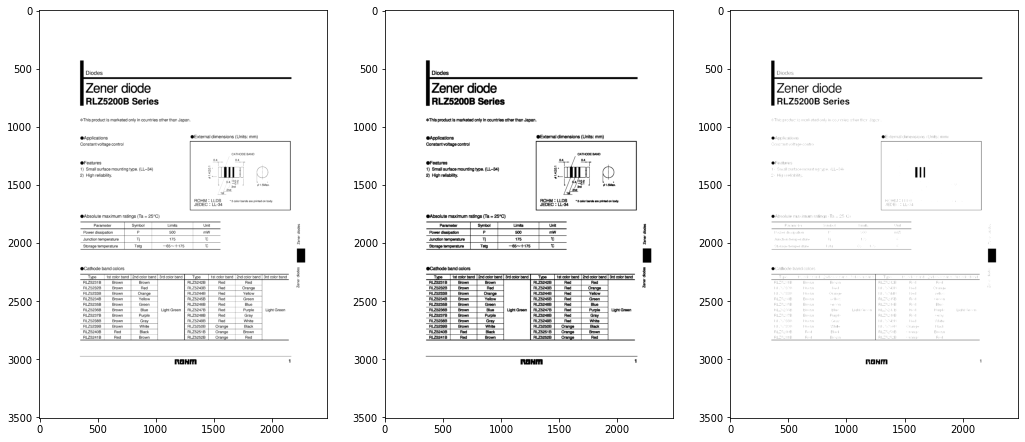

In [ ]:
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(1, 3 
                        , figsize=(img_cv.shape[0]/200, img_cv.shape[1]/200 ))
ax1.imshow( img_cv  ,cmap='gray')
ax2.imshow( erode(img_cv)  ,cmap='gray')
ax3.imshow( dilate(img_cv)  ,cmap='gray')
plt.show()

## Observation:
**The original image looks fine for OCR in this case** 
- Could try eroding with 3,3 filter later

In [ ]:
# pip install --upgrade google-cloud-vision

In [ ]:
!curl -H "apikey:141a09305188957" --form "file=@document-000-113188.in.000.png" --form "language=eng" --form "isOverlayRequired=true" https://api.ocr.space/Parse/Image

curl: (26) read function returned funny value


## Try with the Python API

In [44]:
import requests
def ocr_space( filename,overlay = True
              ,api_key = '141a09305188957', language = 'eng'):

  payload = {
      'isOverlayRequired' : overlay,
      'apikey': api_key,
      'language': language,
  }

  with open(filename, 'rb') as f:
    r = requests.post('https://api.ocr.space/parse/image',
                      files = {filename : f},
                      data = payload,
                      )
    return r.content.decode()

In [45]:
import json
# json_output = json.loads( ocr_space(TEMPLATES_DIR+'/document-000-113188.in.000.png', overlay= False))
# /content/data/Document_Dataset/templates/document-000-113188.in.000.png

In [46]:
list_of_documents = {}
for k in template_store.keys():
  json_output = json.loads( ocr_space(TEMPLATES_DIR+'/'+k
                    , overlay= False))
  document = json_output['ParsedResults'][0]['ParsedText']
  list_doc = document.split(' ')
  # print(list_doc)
  list_of_documents[k] = list_doc
  # with open( k+'.txt', "w") as text_file:
  #   text_file.write(document)
print(list_of_documents)

{'document-001-110866.in.000.png': ['WCC\r\n&atures\r\nMicro', 'Commercial', 'Components\r\n21201', 'Itasca', 'Street', 'Chatsworth\r\nCA', '91311\r\nPhone:', '(818)', '701-4933\r\n(818)', '701-4939\r\nFax:\r\nWide', 'Voltage', 'Range', 'Available\r\nGlass', 'Package\r\nHigh', 'Temp', 'Soldering:', '2500C', 'for', '10', 'Seconds', 'At', 'Terminals\r\nmum', 'æti', 'ngs\r\nOperating', 'Temperature:', '-550C', 'to', '+1500C\r\nStorage', 'Temperature:', '-550C', 'to', '+1500C\r\n2', 'Watt', 'DC', 'Power', 'Dissipation\r\nMaximum', 'Forward', 'Voltage', '@', '200mA:', '1.2', 'Volts\r\nFigure', '1\r\n1.0\r\n-', 'Derating', 'Curve\r\n0', "000'0\r\nBZX2C3V6\r\nTHRU\r\nBZX2C200V\r\n2", 'Watt\r\nZener', 'Diode\r\n3.6', 'to', '200', 'Volts\r\nDO-41', 'GLASS\r\nCathode\r\nMark\r\nc\r\nDIMENSIONS\r\n0\r\n50\r\n100\r\nTemperature', 'oc\r\nVersus\r\n150\r\n-', 'Temperature', 'oc\r\nDIM\r\nC\r\nINCHES\r\nMIN\r\n.030\r\n1.10\r\nMAX\r\n.205\r\n.107\r\n.034\r\nMM\r\nMIN\r\n.762\r\n27.94\r\nMAX\r\n5.21\r\

In [15]:
!pip install gensim --upgrade

Requirement already up-to-date: gensim in /usr/local/lib/python3.7/dist-packages (4.0.1)


In [16]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [17]:
!python --version

Python 3.7.10


In [18]:
import gensim
gensim.__version__

'4.0.1'

In [19]:
Doc2Vec()

In [57]:
# list_of_documents

In [58]:
import os
# txt_list = [ x for x in os.listdir('/content/') if '.txt' in x]
# documents = [ TaggedDocument(doc, [i]) for i, doc in enumerate( txt_list ) ]
# documents
documents = [ TaggedDocument(doc, [i]) for i, doc in enumerate( list_of_documents.values() ) ]
documents

[TaggedDocument(words=['WCC\r\n&atures\r\nMicro', 'Commercial', 'Components\r\n21201', 'Itasca', 'Street', 'Chatsworth\r\nCA', '91311\r\nPhone:', '(818)', '701-4933\r\n(818)', '701-4939\r\nFax:\r\nWide', 'Voltage', 'Range', 'Available\r\nGlass', 'Package\r\nHigh', 'Temp', 'Soldering:', '2500C', 'for', '10', 'Seconds', 'At', 'Terminals\r\nmum', 'æti', 'ngs\r\nOperating', 'Temperature:', '-550C', 'to', '+1500C\r\nStorage', 'Temperature:', '-550C', 'to', '+1500C\r\n2', 'Watt', 'DC', 'Power', 'Dissipation\r\nMaximum', 'Forward', 'Voltage', '@', '200mA:', '1.2', 'Volts\r\nFigure', '1\r\n1.0\r\n-', 'Derating', 'Curve\r\n0', "000'0\r\nBZX2C3V6\r\nTHRU\r\nBZX2C200V\r\n2", 'Watt\r\nZener', 'Diode\r\n3.6', 'to', '200', 'Volts\r\nDO-41', 'GLASS\r\nCathode\r\nMark\r\nc\r\nDIMENSIONS\r\n0\r\n50\r\n100\r\nTemperature', 'oc\r\nVersus\r\n150\r\n-', 'Temperature', 'oc\r\nDIM\r\nC\r\nINCHES\r\nMIN\r\n.030\r\n1.10\r\nMAX\r\n.205\r\n.107\r\n.034\r\nMM\r\nMIN\r\n.762\r\n27.94\r\nMAX\r\n5.21\r\n2.72\r\n.864

In [59]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [60]:
model = Doc2Vec(documents,
                vector_size=500  # size of output embedding
                 , window = 4    # max continuos words to consider
                , min_count=1    # minimum number of words that are valid
                , workers=4
                , epochs=500)

2021-07-07 18:46:09,214 : INFO : collecting all words and their counts
2021-07-07 18:46:09,217 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2021-07-07 18:46:09,221 : INFO : collected 1278 word types and 20 unique tags from a corpus of 20 examples and 2225 words
2021-07-07 18:46:09,224 : INFO : Creating a fresh vocabulary
2021-07-07 18:46:09,236 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=1 retains 1278 unique words (100.0%% of original 1278, drops 0)', 'datetime': '2021-07-07T18:46:09.236843', 'gensim': '4.0.1', 'python': '3.7.10 (default, May  3 2021, 02:48:31) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'prepare_vocab'}
2021-07-07 18:46:09,239 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 2225 word corpus (100.0%% of original 2225, drops 0)', 'datetime': '2021-07-07T18:46:09.239122', 'gensim': '4.0.1', 'python': '3.7.10 (default, May  3 2021, 02:48:31) \n[GCC 7.5.0

In [61]:
model.get_latest_training_loss()

0.0

In [62]:
model.build_vocab(documents)

2021-07-07 18:46:55,884 : INFO : collecting all words and their counts
2021-07-07 18:46:55,888 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2021-07-07 18:46:55,891 : INFO : collected 1278 word types and 20 unique tags from a corpus of 20 examples and 2225 words
2021-07-07 18:46:55,895 : INFO : Creating a fresh vocabulary
2021-07-07 18:46:55,907 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=1 retains 1278 unique words (100.0%% of original 1278, drops 0)', 'datetime': '2021-07-07T18:46:55.906681', 'gensim': '4.0.1', 'python': '3.7.10 (default, May  3 2021, 02:48:31) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'prepare_vocab'}
2021-07-07 18:46:55,909 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 2225 word corpus (100.0%% of original 2225, drops 0)', 'datetime': '2021-07-07T18:46:55.909113', 'gensim': '4.0.1', 'python': '3.7.10 (default, May  3 2021, 02:48:31) \n[GCC 7.5.0

In [63]:
model.train(documents,total_examples=model.corpus_count
            , epochs=model.epochs
            )

2021-07-07 18:47:02,033 : WARNING : Effective 'alpha' higher than previous training cycles
2021-07-07 18:47:02,037 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 4 workers on 1278 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=5 window=4', 'datetime': '2021-07-07T18:47:02.037280', 'gensim': '4.0.1', 'python': '3.7.10 (default, May  3 2021, 02:48:31) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'train'}
2021-07-07 18:47:02,050 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-07-07 18:47:02,052 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-07-07 18:47:02,056 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-07-07 18:47:02,070 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-07-07 18:47:02,072 : INFO : EPOCH - 1 : training on 2225 raw words (2069 effective words) took 0.0s, 92835 effective words/s
2021-07-07 18:47:02,082

In [64]:
model.get_latest_training_loss()

0.0

In [71]:
model.save('doc2vec_model_500_5')

2021-07-07 18:49:15,678 : INFO : Doc2Vec lifecycle event {'fname_or_handle': 'doc2vec_model_500_5', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2021-07-07T18:49:15.677955', 'gensim': '4.0.1', 'python': '3.7.10 (default, May  3 2021, 02:48:31) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'saving'}
2021-07-07 18:49:15,682 : INFO : not storing attribute cum_table
2021-07-07 18:49:15,698 : INFO : saved doc2vec_model_500_5


In [67]:
vectors_train = { doc : model.infer_vector(documents[i][0]).tolist()
 for i, doc in enumerate( list_of_documents.keys() ) }

In [68]:
# import numpy as np
# distances = [ np.linalg.norm(vector-vec) for vec in vectors_train] #L2( Euclidean distance)
# np.argmin(distances)
# this is correct

## Store the document embeddings in corresponding template_store

In [69]:
json_string = json.dumps(vectors_train, indent=4)

In [70]:
# vectors_train
with open('/content/data/vectors_train.json', "w") as outfile: 
    json.dump(vectors_train, outfile)